## Set up your FABRIC environment


In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,nm3833_0000195331
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,nm3833_0000195331
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


## Get slice details

Put your slice name and the number of endpoints in the following cell:

In [2]:
n_endpoints = 2
slice_name = "re-when-to-use-bbr-" + fablib.get_bastion_username()
slice = fablib.new_slice(name=slice_name)

In [3]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")

You already have a slice by this name!
If you previously reserved resources, skip to the 'log in to resources' section.


In [4]:
sender_node = slice.get_node(name='h1')
receiver_node = slice.get_node(name='h3')
router_node = slice.get_node(name='tbf')
router_ingress_iface = router_node.get_interface(network_name = "link1")
router_egress_iface  = router_node.get_interface(network_name = "link3")
router_egress_name = router_egress_iface.get_device_name()
router_ingress_name=router_ingress_iface.get_device_name()

### Configure Sender

In [33]:
sender_node.execute("wget -O ss-output.sh https://raw.githubusercontent.com/ffund/tcp-ip-essentials/cloudlab/scripts/ss-output.sh")
sender_node.execute('chmod +x ss-output.sh')
sender_node.execute('sudo apt-get install moreutils -y', quiet=True)

 --2024-08-02 16:59:36--  https://raw.githubusercontent.com/ffund/tcp-ip-essentials/cloudlab/scripts/ss-output.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1274 (1.2K) [text/plain]
Saving to: ‘ss-output.sh’

     0K .                                                     100% 81.4M=0s

2024-08-02 16:59:37 (81.4 MB/s) - ‘ss-output.sh’ saved [1274/1274]

 Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libio-pty-perl libipc-run-perl libtime-duration-perl libtimedate-perl
The following NEW packages will be installed:
  libio-pty-perl libipc-run-perl libtime-duration-perl libtimedate-perl
  moreutils
0 upgraded, 5 newly installed, 0 to remove and 32 not u

('Reading package lists...\nBuilding dependency tree...\nReading state information...\nThe following additional packages will be installed:\n  libio-pty-perl libipc-run-perl libtime-duration-perl libtimedate-perl\nThe following NEW packages will be installed:\n  libio-pty-perl libipc-run-perl libtime-duration-perl libtimedate-perl\n  moreutils\n0 upgraded, 5 newly installed, 0 to remove and 32 not upgraded.\nNeed to get 235 kB of archives.\nAfter this operation, 778 kB of additional disk space will be used.\nGet:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/main amd64 libio-pty-perl amd64 1:1.15-2build2 [35.1 kB]\nGet:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/main amd64 libipc-run-perl all 20200505.0-1 [89.8 kB]\nGet:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/main amd64 libtime-duration-perl all 1.21-1 [13.1 kB]\nGet:4 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/main amd64 libtimedate-perl all 2.3300-2 [34.0 kB]\nGet:5 http://nova.clouds.archive.ubunt

### Configure Router

In [15]:
import os

In [5]:
router_node.upload_file(os.path.join(os.getcwd(), 'monitor_queue.sh'),'monitor_queue.sh')
router_node.execute('chmod +x monitor_queue.sh')

('', '')

In [6]:
router_node.execute('sudo ethtool  -K ' + router_egress_name + ' hw-tc-offload off')
router_node.execute('sudo ethtool  -k ' + router_egress_name + " | grep hw-tc-offload" )

hw-tc-offload: off


('hw-tc-offload: off\n', '')

In [9]:
router_node.execute("sudo tc qdisc del dev " + router_egress_name + " root")
router_node.execute("sudo tc qdisc del dev " + router_ingress_name + " root")

('', '')

In [10]:
router_node.execute("sudo tc qdisc add dev "+ router_ingress_name + " root netem delay 10ms limit 10000")
router_node.execute("sudo tc qdisc add dev " + router_egress_name + " root handle 1: tbf rate 1Gbit burst 0.5m limit 10000")
router_node.execute("sudo tc qdisc add dev " + router_egress_name + " parent 1: handle 2: bfifo limit 100kb")

('', '')

### SSH Commands

Use the following ssh commands to ssh to each node and run the iperf comands.

In [9]:
print("sender_node (h1): ", sender_node.get_ssh_command())
print("receiver_node (h3): ", receiver_node.get_ssh_command())
print("router_node (tbf): ", router_node.get_ssh_command())

sender_node (h1):  ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:feaf:81bd
receiver_node (h3):  ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe3d:9609
router_node (tbf):  ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe2f:b83f


### iperf Commands

Run in the given order.

Receiver Terminal
```bash
$  iperf3 -s -1 -f m
```

Sender Terminal 1
```bash
$  bash ss-output.sh 10.10.3.1
```

Router Terminal
```bash
$  bash monitor_queue.sh
```
Sender Terminal 2
```bash
$  iperf3 -V -t 60 -P 1 -c 10.10.3.1 -C cubic
```

### Retrieve Data

In [21]:
router_node.download_file(os.path.join(os.getcwd(),'data/backlog_log.txt'),'backlog_log.txt')
router_node.download_file(os.path.join(os.getcwd(),'data/Dropped.txt'),'Dropped.txt')
sender_node.download_file(os.path.join(os.getcwd(),'data/sender-ss.csv'),'sender-ss.csv')

### Plot

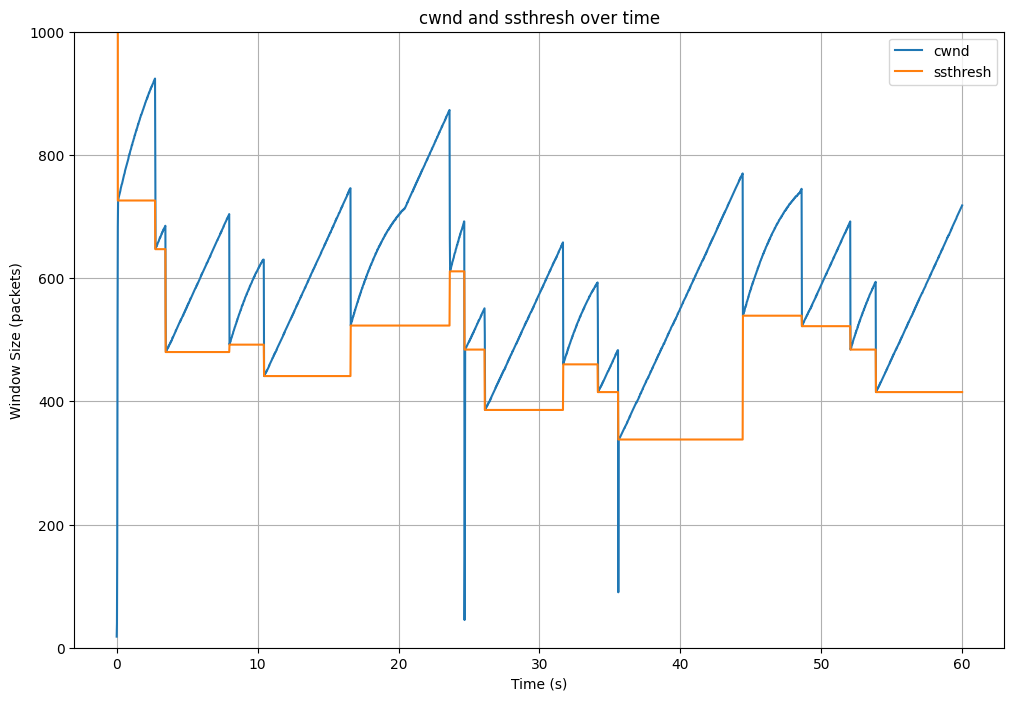

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(f"data/sender-ss.csv", names=['time', 'sender', 'retx_unacked', 'retx_cum', 'cwnd', 'ssthresh', 'rtt'])

# Filter data for a specific sender (replace 'specific_sender' with the actual sender identifier)

df_filtered = df[df['sender'] == df['sender'].value_counts().idxmax()]

time_min = df_filtered.time.min()
cwnd_max = 1.1* df_filtered.cwnd.max()
# Check if there is data for the specific sender
if df_filtered.empty:
    print("No data for the specific sender")
    exit()

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(df_filtered['time']-time_min, df_filtered['cwnd'], label='cwnd')
plt.plot(df_filtered['time']-time_min, df_filtered['ssthresh'], label='ssthresh')
plt.xlabel('Time (s)')
plt.ylabel('Window Size (packets)')
plt.legend()
plt.title('cwnd and ssthresh over time')
plt.ylim(0, 1000)
plt.grid()
plt.savefig('data/sender-ss.png')
plt.show()

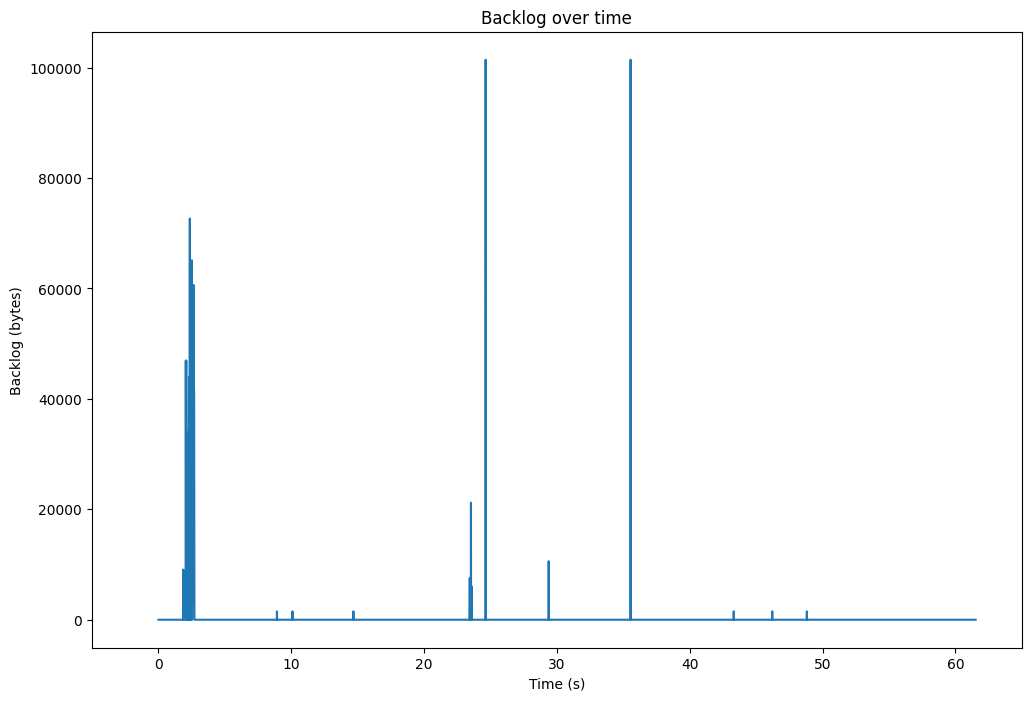

In [23]:
df_backlog = pd.read_csv(f"data/backlog_log.txt", names = ['time', 'bytes', 'packets'], sep=' ')
df_backlog = df_backlog[df_backlog['time'].astype(float)>time_min]
df_backlog['time'] = df_backlog['time'].astype(float) - time_min
df_backlog['bytes'] = df_backlog['bytes'].str.replace('b','').str.replace('K','000').str.replace('M','000000').astype(int)
df_backlog['packets'] = df_backlog['packets'].str.replace('p','').astype(int)
# df_backlog.head()
plt.figure(figsize=(12, 8))
plt.plot(df_backlog['time'], df_backlog['bytes'])
plt.xlabel("Time (s)")
plt.ylabel("Backlog (bytes)")
plt.title("Backlog over time")
plt.xlim(-5,65)
plt.savefig("data/backlog.png")
plt.show()

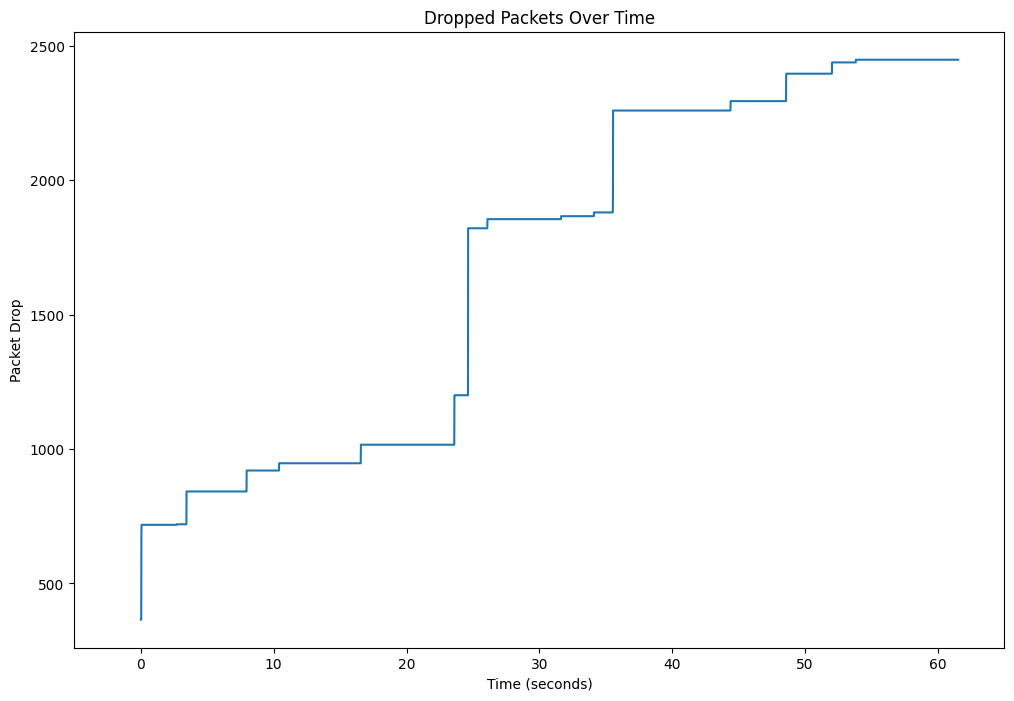

In [24]:
df_qDrop = pd.read_csv(f"data/Dropped.txt", sep=r'\s+', header=None, names=['time', 'dropped']).reset_index()
df_qDrop.drop(columns=['index'], inplace=True)
df_qDrop['time'] = df_qDrop['time'].astype(float)

# print(df_qDrop.tail())
df_qDrop = df_qDrop[df_qDrop['time'] >= time_min]
# print(df_qDrop.tail())
df_qDrop['time'] = df_qDrop['time'].apply(lambda x: (x - time_min))  # Convert to seconds
df_qDrop.set_index('time', inplace=True)
df_qDrop['dropped'] = df_qDrop['dropped'].str.replace(',', '').astype(int)

# df_qDrop['drop_change'] = df_qDrop['dropped'].diff().fillna(0).astype(bool)
# filtered = df_qDrop[df_qDrop['drop_change']]

# plt.figure(figsize=(10, 6))
# Plot vertical lines at the points where there is a drop change
# for time in filtered.index:
#     plt.axvline(x=time, color='red', linestyle='--', label='Packet Drop')
plt.figure(figsize=(12, 8))
plt.plot(df_qDrop.index, df_qDrop['dropped'])
# df_qDrop.plot()
plt.xlabel('Time (seconds)')
plt.ylabel('Packet Drop')
plt.xlim(-5,65)
plt.title('Dropped Packets Over Time')
# plt.legend()
plt.savefig('data/packet_drop.png')
plt.show();